# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
# img = mpimg.imread('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
# Calculate the undistortion parameters
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, gray.shape[::-1], None, None)

## Helper functions

In [2]:

# Undistort the image
def undistort(img, mtx=mtx, dist=dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Perspective transform function
def perspective_transform(img):
    img_size = (img.shape[1],img.shape[0])
#     src = np.float32([[525,500],[766,500],[1060,700],[240,700]])  
    src = np.float32([[600,445],[680,445],[1060,700],[240,700]])
    dst = np.float32([[240,0],[1060,0],[1060,720],[240,720]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

# Colors and gradient combined transform
def color_gradient_transform(img, s_thresh=(170,255), sx_thresh=(20,100)):
    # Cover to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>=sx_thresh[0])&(scaled_sobel<=sx_thresh[1])] = 1
    # Threshold s channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel>=s_thresh[0])&(s_channel<=s_thresh[1])] = 1
    # Combine the two binary threshold
    combine_binary = np.zeros_like(sxbinary)
    combine_binary[(sxbinary==1)|(s_binary==1)] = 1;
    return combine_binary
    
# Find lane pixels function
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 12
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 10
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify the boundaries in y
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Identify the boundaries in x
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)       
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]  
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
        & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]        
    
        # Append the indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found > minpix pixels, recenter next window
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        pass
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except valueError:
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, leftx_current, rightx_current, out_img

def fit_polynomial(binary_warped):
    leftx, lefty, rightx, righty, leftx_current, rightx_current,out_img = find_lane_pixels(binary_warped)
    
    # Define conversions in x from pixels space to meters
    
    xm_per_pix = 3.7/820
    
    # Find the fitting polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    #Compute the distance from the road centerline
    y_eval = img.shape[0]
#     left_lane_bottom = np.polyval(left_fit, img.shape[0])
#     right_lane_bottom = np.polyval(right_fit, img.shape[0])
    left_lane_bottom = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_bottom = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    
    dist_from_center = ((left_lane_bottom + right_lane_bottom)/2 - binary_warped.shape[1]/2)*xm_per_pix
    
    # Colors in left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]   
    
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return ploty, left_fit, right_fit, left_fitx, right_fitx, leftx_current, rightx_current,dist_from_center, out_img
    
def measure_curvature_real(ploty, left_fit, right_fit):
    
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720
    xm_per_pix = 3.7/820
    
    # Implement the calculation of R_Curve
    left_curverad = ((1+(2*left_fit[0]*y_eval+left_fit[1])**2*(xm_per_pix*24)**2)
    **1.5)/np.absolute(2*left_fit[0])/(xm_per_pix*24**2)
    right_curverad = ((1+(2*right_fit[0]*y_eval+right_fit[1])**2*(xm_per_pix*24)**2)
    **1.5)/np.absolute(2*right_fit[0])/(xm_per_pix*24**2)
    avg_curverad = (left_curverad + right_curverad)/2
    return left_curverad, right_curverad, avg_curverad

def project_lines(warped, left_fitx, right_fitx, ploty, Minv, image):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

def annotate_image(img, avg_curverad, dist_from_center):
    
    new_img = np.copy(img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_color = (255,255,255)
    num_format = '{:04.2f}'
    text = 'Radius of Curvature: ' + num_format.format(avg_curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, font_color, 2, cv2.LINE_AA)
    direction = 'left'
    if dist_from_center > 0:
        direction = 'right'
    abs_dist = abs(dist_from_center)
    text = 'Vehicle is ' + num_format.format(abs_dist) + ' m ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, font_color, 2, cv2.LINE_AA)  
    
    return new_img
    
def process_image(img):
    # Undistort the image
    undist = undistort(img, mtx, dist)
    # Gradient and color binary transform
    binary = color_gradient_transform(undist)
    # Perform the perspective transform
    transformed, Minv = perspective_transform(binary)
    # Plot the histogram
    ploty, left_fit, right_fit, left_fitx, right_fitx, leftx_current, rightx_current,dist_from_center, fitted = fit_polynomial(transformed)
    
    # Measuring the curvature and deviation to roadcenter
    left_curverad, right_curverad,avg_curverad = measure_curvature_real(ploty, left_fit, right_fit)
    # Project lines back onto the original image
    linesProjected = project_lines(transformed, left_fitx, right_fitx, ploty, Minv, img)
    # Annotate the image
    annotated_image =  annotate_image(linesProjected, avg_curverad, dist_from_center)
    
    return annotated_image

## Undistort the image and perform the pespective transform into birds eye view

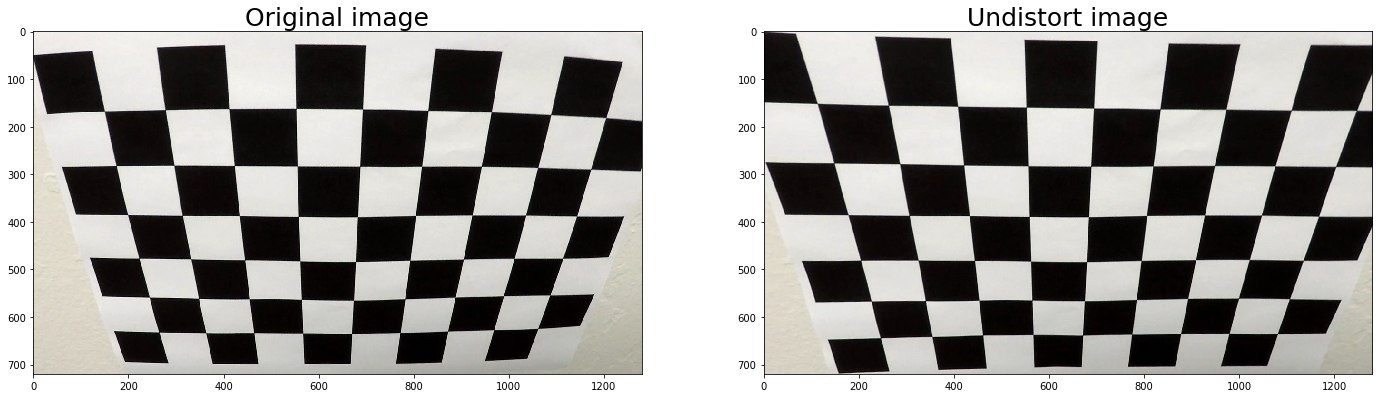

In [25]:
# Undistort the chessboard example
img_chess = mpimg.imread('../camera_cal/calibration2.jpg')
undist_chess = undistort(img_chess)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img_chess)
ax2.imshow(undist_chess)   
ax1.title.set_text('Original image')
ax2.title.set_text('Undistort image')
ax1.title.set_fontsize(25)
ax2.title.set_fontsize(25)
plt.savefig('../output_images/ChessboardUndistortion.jpg')
# # Read the image
# img = mpimg.imread('../test_images/straight_lines2.jpg')
# # Undistort the image
# undist = undistort(img)
# # Gradient and color binary transform
# binary = color_gradient_transform(undist)
# # Perform the perspective transform
# transformed, Minv = perspective_transform(binary)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# ax1.imshow(undist)
# ax2.imshow(transformed)             

# Undistort the video clip
# white_output = '../output_images/undistort_test.mp4'
# clip1 = VideoFileClip('../project_video.mp4').subclip(0,5)
# white_clip = clip1.fl_image(cal_undistort)
# %time white_clip.write_videofile(white_output, audio=False)
# HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(white_output))


## Obtain the sliding window, fit polynomial plot and measuring the curvature

In [68]:
# # Plot the histogram
# ploty, left_fit, right_fit, left_fitx, right_fitx, fitted = fit_polynomial(transformed)
# plt.imshow(fitted)
# # Measuring the curvature
# left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)
# print(left_curverad, right_curverad)

## Project the lines back onto the original image

In [69]:
# # Project lines back onto the original image
# linesProjected = project_lines(transformed, left_fitx, right_fitx, ploty, Minv, img)
# plt.imshow(linesProjected)

## Process the video

[MoviePy] >>>> Building video ../output_images/ProjectLines.mp4
[MoviePy] Writing video ../output_images/ProjectLines.mp4


100%|█████████▉| 1260/1261 [04:04<00:00,  4.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/ProjectLines.mp4 

CPU times: user 1min 57s, sys: 8.35 s, total: 2min 5s
Wall time: 4min 7s


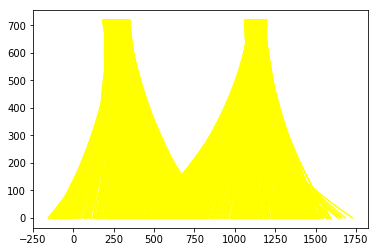

In [71]:
# Undistort the video clip
white_output = '../output_images/ProjectLines.mp4'
clip1 = VideoFileClip('../project_video.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(white_output))